The following example shows how to train a model. Get a list of training data csv file in the selected folder. Lessons learned so far:
- Training result is very sensitive to normalization. The normalization approach based on mean and variance does not work very well. Still need to manually set mean and variance.
- t-sne plot of adapter trace is an important flag of training result. 
- h net does not have to descent because phi net training strives to make it rise, while h net training itself tries to lower the loss
- Increase the h training frequency to fight against rising h 
- Increase alpha to push domain info to adapter
- Increase number of features to minimize MSE loss.
- ocassional small spike in cross entropy loss is possibly a sign that phi net become further domain invariant and may not be bad.
- at the late stage of training while both mse loss and cross entropy loss converge. May need to train h net every step to refine the optimization direction.

Existing problem:
- The more classes, the harder to train. The difficulty comes from instability of loss_f and loss_c. alpha is hard to tune.
- t-sne gets worse as epoch grows and the cross entropy loss remains the same. 

In [ ]:
import os
import matplotlib.pyplot as plt

import trainer

current_dir = os.getcwd()
# subfolder = "wind_near_wall"
# subfolder = "wind_near_wall_inflow_in_control_train_xz_wind_2"
# subfolder = "wind_near_wall_inflow_in_control_train_xz_wind_2_only_x"
# subfolder = "wind_near_wall_inflow_in_control_train_xz_wind_2_limited"
# subfolder = "wind_near_wall_wo_inflow_in_control_train_xz_wind_2"
subfolder = "wind_near_wall_wo_inflow_in_control_train_xz_wind_2_limited"
# subfolder = "training_back2back"
folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Filter out files that do not end with .csv
file_names = [f for f in file_names if f.endswith('.csv')]
# add subfolder to the file names
data_list = [os.path.join(subfolder, f) for f in file_names]
for data in data_list:
    print(data)

path1 = os.path.join(subfolder, "input_label_map_disturbance_force_label.yaml")
path2 = os.path.join(subfolder, "column_map.yaml")

wind_near_wall_inflow_in_control_train_xz_wind_2_limited\test_wind_near_wall_x0_0_y0_0_z0_0_d0_5_inflow.csv
wind_near_wall_inflow_in_control_train_xz_wind_2_limited\test_wind_near_wall_x0_0_y0_0_z3_0_d0_5_inflow.csv
wind_near_wall_inflow_in_control_train_xz_wind_2_limited\test_wind_near_wall_x0_0_y0_0_z5_0_d0_5_inflow.csv
wind_near_wall_inflow_in_control_train_xz_wind_2_limited\test_wind_near_wall_x0_0_y0_0_zn3_0_d0_5_inflow.csv
wind_near_wall_inflow_in_control_train_xz_wind_2_limited\test_wind_near_wall_x0_0_y0_0_zn5_0_d0_5_inflow.csv
wind_near_wall_inflow_in_control_train_xz_wind_2_limited\test_wind_near_wall_xn1_0_y0_0_z0_0_d0_5_inflow.csv
wind_near_wall_inflow_in_control_train_xz_wind_2_limited\test_wind_near_wall_xn1_0_y0_0_z3_0_d0_5_inflow.csv
wind_near_wall_inflow_in_control_train_xz_wind_2_limited\test_wind_near_wall_xn1_0_y0_0_z5_0_d0_5_inflow.csv
wind_near_wall_inflow_in_control_train_xz_wind_2_limited\test_wind_near_wall_xn1_0_y0_0_zn3_0_d0_5_inflow.csv
wind_near_wall_inflow

- Make sure the input_label_map_disturbance_force_label.yaml is in the selected folder. This yaml defines which fields are model inputs and which fields are data labels. 
- Make sure the column_map.yaml is in the selected folder. This yaml maps data fields to the corresponding column in the csv files. This file can be auto-generated by `Simulation\simulation\training_data_user_guide.ipynb`
- If this is the first time to train on this data. The script will normalize the data and save the normalization parameters into a file.

Loading normalization params file from
..\data\training\wind_near_wall_inflow_in_control_train_xz_wind_2_limited\normalization_params.yaml
[1] loss_f: 0.06 loss_c: 2.72
[101] loss_f: 0.00 loss_c: 2.72
[201] loss_f: 0.00 loss_c: 2.71
[301] loss_f: 0.00 loss_c: 2.71
[401] loss_f: 0.00 loss_c: 2.71
[501] loss_f: 0.00 loss_c: 2.71
[601] loss_f: -0.00 loss_c: 2.71
[701] loss_f: -0.00 loss_c: 2.71
[801] loss_f: -0.00 loss_c: 2.71
[901] loss_f: -0.00 loss_c: 2.71
a = tensor([[ 3.8585e-01,  1.6934e-01,  5.8114e-01],
        [ 9.2476e-01,  8.4097e+00, -1.3699e-01],
        [-5.0610e-01, -8.4094e-01, -3.3694e-01],
        [-2.2721e+00,  1.2031e+00,  2.0375e-01],
        [ 1.9848e+00, -2.9099e+00, -5.6227e-01],
        [ 2.5413e+00,  9.8946e-01, -3.4534e-03]])


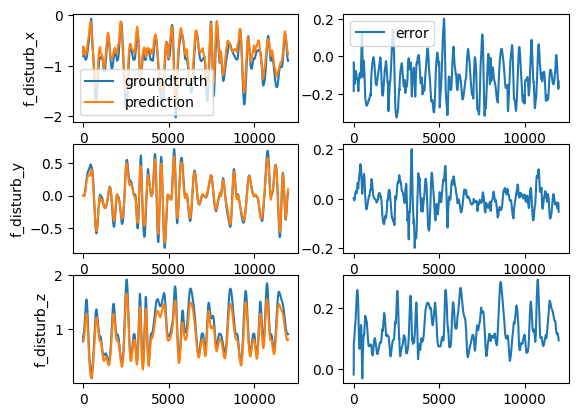

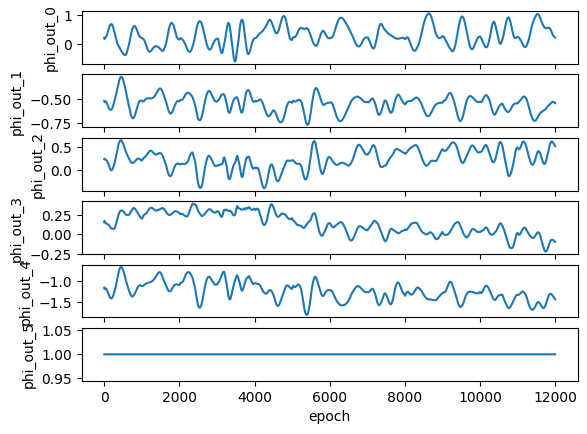

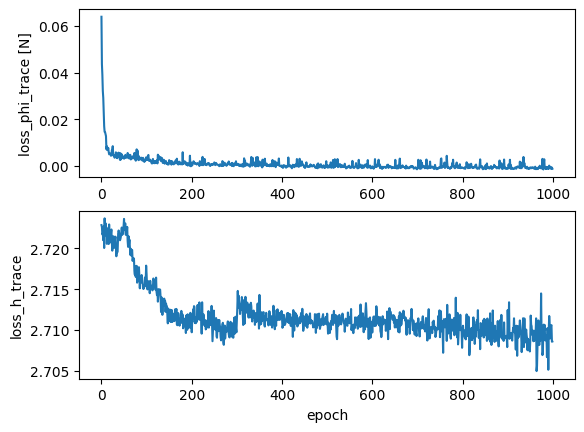

In [2]:
# use the data from previous section to train the model
trainer_instance = trainer.Trainer(
    data_menu=data_list,
    input_label_map_file=path1,
    column_map_file=path2,
    can_skip_io_normalizaiton=False
)
# trainer_instance = trainer.Trainer(data_list[:4], path1, path2)   # use small data list for quick testing
trainer_instance.train_model()
trainer_instance.verify_model([data_list[-1]])

trainer_instance.plot_loss()

plt.show()  

Inspect data in the data list.

In [6]:
# trainer_instance.inspect_data(data_list[:2])
trainer_instance.plot_loss()

Inspect t-sne of a_trace.

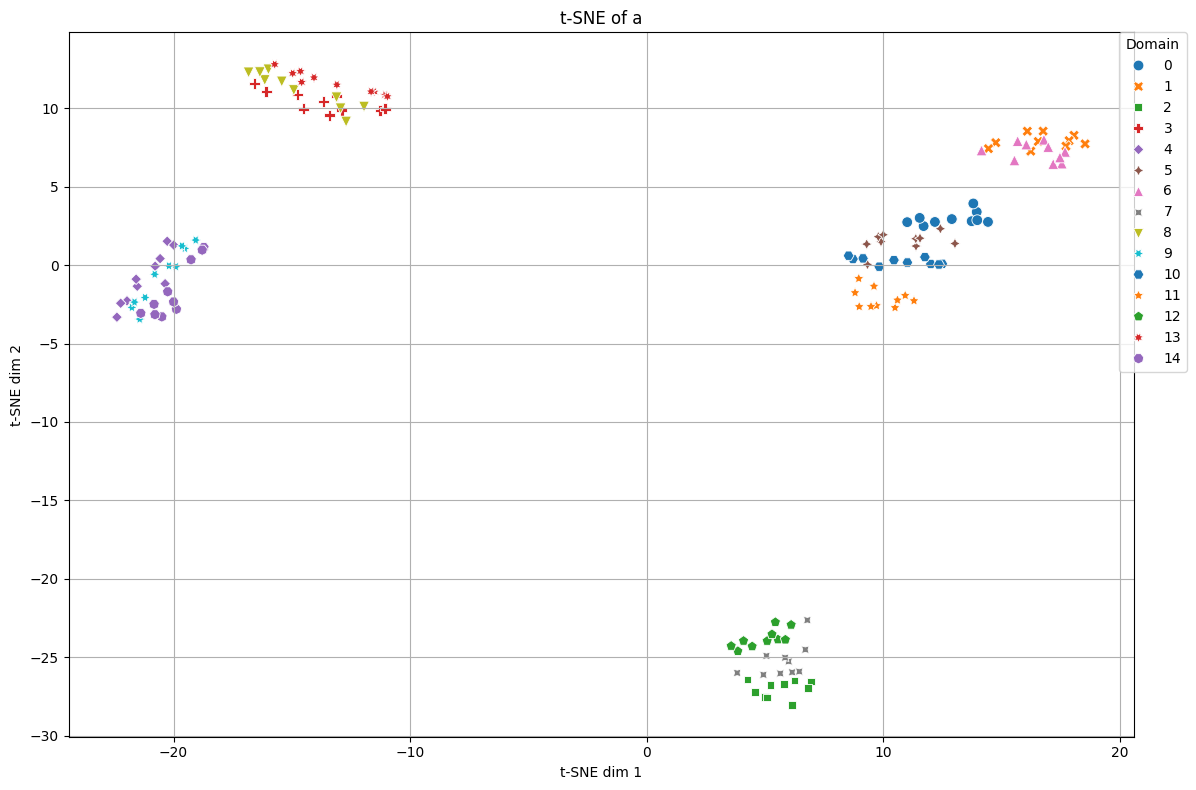

In [5]:
import performance_analyzer
n = 990
performance_analyzer.plot_tsne_of_a(trainer_instance.a_trace, list(range(n, n + 10)))
plt.show()  

In [8]:
import performance_analyzer
%matplotlib tk
n = 450
performance_analyzer.plot_tsne_3d_of_a(trainer_instance.a_trace, list(range(n, n + 10)))


After training, we can save the model in the following way.

In [10]:
model_name = subfolder

trainer_instance.save_model(model_name)
phi, h, config = trainer.load_model(model_name)
# make a new trainer to replicate the above setup, just to allow verify_model to work
trainer_for_verification = trainer.Trainer(data_list[:2], path1, path2, True)
trainer_for_verification.phi_net = phi
trainer_for_verification.h_net = h
trainer_for_verification.verify_model([data_list[-1]])
plt.show()  

print("phi net input output fields:")
for key, value in config["phi_net_io_fields"].items():
    print(key, value)


Model saved to model\wind_near_wall_inflow_in_control_train_xz_wind_2_limited.pth
Loading normalization params file from
..\data\training\wind_near_wall_inflow_in_control_train_xz_wind_2_limited\normalization_params.yaml
a = tensor([[ 6.3523e-01,  2.7502e-03,  7.6244e-01],
        [ 6.4173e-01,  8.2751e+00, -3.2774e-02],
        [ 1.5690e-01, -4.8622e-01, -2.9921e-01],
        [-3.1627e+00,  1.7180e+00,  5.1241e-01],
        [ 1.4735e+00, -3.1224e+00, -3.5157e-01],
        [ 2.0789e+00,  4.2494e-01, -1.0817e-01]])
phi net input output fields:
input ['position_x', 'position_y', 'position_z', 'q_0', 'q_1', 'q_2', 'q_3', 'v_x', 'v_y', 'v_z', 'omega_x', 'omega_y', 'omega_z', 'f_ctrl_input_z', 'torque_ctrl_input_x', 'torque_ctrl_input_y', 'torque_ctrl_input_z', 'rotor_0_rotation_spd', 'rotor_1_rotation_spd', 'rotor_2_rotation_spd', 'rotor_3_rotation_spd']
label ['f_disturb_x', 'f_disturb_y', 'f_disturb_z']
